In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import os
from random import randint
from os import listdir
from os.path import isfile, join

# some cutoffs to play with:
max_invalid_key_pairs = 8
margin = 3
singlefile = False
filedir = ""
filename = ""
path_to_datasets = "../datasets/"

protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 
'R-Wr', 'L-Sho', 'L-Elb', 'L-Wr', 
'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip',
 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 
 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44],
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30],
          [47,48], [49,50], [53,54], [51,52], [55,56],
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]




In [2]:
def getKeypoints(probMap, threshold=0.1):

    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []

    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints



In [3]:

# Find valid connections between the different joints of a all persons present
def getValidPairs(output, frameWidth, frameHeight, detected_keypoints):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid

        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ])
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            #print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    return valid_pairs, invalid_pairs




In [4]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
def getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list):
    # the last number in each row is the overall score
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])):
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints


In [15]:
def perform_keypoint_analysis(filename):
    print(filename)
    image1 = cv2.imread(filename)
    
    frameWidth = image1.shape[1]
    frameHeight = image1.shape[0]

    t = time.time()
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                            (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()
    #print("Time Taken in forward pass = {}".format(time.time() - t))

    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
        keypoints = getKeypoints(probMap, threshold)
        #print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1

        detected_keypoints.append(keypoints_with_id)


    frameClone = image1.copy()
    for i in range(nPoints):
        for j in range(len(detected_keypoints[i])):
            cv2.circle(frameClone, detected_keypoints[i][j][0:2], 5, colors[i], -1, cv2.LINE_AA)
    #cv2.imshow("Keypoints",frameClone)

    valid_pairs, invalid_pairs = getValidPairs(output, frameWidth, frameHeight, detected_keypoints)

    personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list)

    for i in range(17):
        for n in range(len(personwiseKeypoints)):
            index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
            if -1 in index:
                continue
            B = np.int32(keypoints_list[index.astype(int), 0])
            A = np.int32(keypoints_list[index.astype(int), 1])
            cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
    if(len(invalid_pairs) > max_invalid_key_pairs):
        savedname = path_to_datasets + "thrown_out/" + filename
        cv2.imwrite(savedname , frameClone)
    elif(len(invalid_pairs) > max_invalid_key_pairs + margin):
        savedname = path_to_datasets + "on_the_edge/" + filename
        cv2.imwrite(savedname , frameClone)
    else:
        savedname = path_to_datasets + "approved/" + filename
        cv2.imwrite(savedname , frameClone)

    return valid_pairs, invalid_pairs, personwiseKeypoints, keypoints_list, frameClone
    #cv2.waitKey(0)



In [16]:

def classify_file(filename):
    valid, invalid, personwiseKeypoints, keypoints_list, frameClone = perform_keypoint_analysis(filename)
    missing = []
    print("File: " + filename)
    i = 0
    for el in valid:
        if el != []:
            missing.append(i)
        i += 1
    print("number of valid pairs: " + str(len(missing)))
    #print(missing)
    '''
    for el in missing:
        tupl = POSE_PAIRS[el]
        print(str(keypointsMapping[tupl[0]]) + " -> " + str(keypointsMapping[tupl[1]]))
    '''
    print("number of invalid pairs: " + str(len(invalid)))
    #print(invalid)
    '''
    for el in invalid:
        tupl = POSE_PAIRS[el]
        print(str(keypointsMapping[tupl[0]]) + " -> " + str(keypointsMapping[tupl[1]]))
    '''
    if len(invalid) > max_invalid_key_pairs:
        print("~~~~~~~~~~~~~~~~~~~~\nFile does not pass minimum required keypoints.")
    elif apply_filter(invalid) is False:
        print("~~~~~~~~~~~~~~~~~~~~\nFile does not pass filter.")
    else:
        print("~~~~~~~~~~~~~~~~~~~~\nFile does pass filter.")

    return personwiseKeypoints, keypoints_list, frameClone

In [7]:
# returns true if passed filter, false if not
def apply_filter(invalid):
    '''
        keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 
        'R-Wr', 'L-Sho', 'L-Elb', 'L-Wr', 
        'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip',
         'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 
         'R-Ear', 'L-Ear']

        POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
                      [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
                      [1,0], [0,14], [14,16], [0,15], [15,17],
                      [2,17], [5,16] ]
    '''
    
    '''
    for each list, you need at least one keypoint:
    [r-eye, l-eye, 'r-ear', 'l-ear']
    [r-elb, r-wr]
    [l-elb, l-wr]
    
    need all:
    [l-ank, r-ank]
    '''
    # set up lists of keypoints that must not be in the invalid list
    required_keypoints = []
    minimum_keypoints = []
    for item in ["L-Ank", "R-Ank"]:
        required_keypoints.append(keypointsMapping.index(item))

    for outer in [['R-Eye', 'L-Eye', 'R-Ear', 'L-Ear'], 
                 ['R-Elb', 'R-Wr'],
                 ['L-Elb', 'L-Wr']
                ]:
        to_append = []
        for inner in outer:
            to_append.append(keypointsMapping.index(inner))
        minimum_keypoints.append(to_append)
        
    #print(required_keypoints)
    #print(minimum_keypoints)
    
    # now check if the required ones are all there
    for req_kp in required_keypoints:
        if req_kp in invalid:
            return False
    
    # now check that at least one of each list for minimum_keypoints is not in invalid
    for kp_set in minimum_keypoints:
        kp_valid = [i for i in kp_set if i not in invalid]
        if len(kp_valid) < 1:
            return False
    return True
        


In [17]:
def classify_folder(filedir):
    if os.path.isdir(filedir) is False:
        print(filedir + " is not a folder.")
        return None
    elif filedir[len(filedir) - 1] is not "/":
        filedir += "/"
    try:
        os.mkdir(path_to_datasets + "approved")
    except OSError:
        pass
    try:
        os.mkdir(path_to_datasets + "on_the_edge")
    except OSError:
        pass
    try:
        os.mkdir(path_to_datasets + "thrown_out")
    except OSError:
        pass

    try:
        os.mkdir(path_to_datasets + "approved/" + filedir)
    except OSError:
        pass

    try:
        os.mkdir(path_to_datasets + "on_the_edge/" + filedir)
    except OSError:
        pass

    try:
        os.mkdir(path_to_datasets + "thrown_out/" + filedir)
    except OSError:
        pass
    onlyfiles = [filedir + f for f in listdir(filedir) if (isfile(join(filedir, f)) and (".jpg" in f or ".png" in f))]
    #print(onlyfiles)
    good_files = []
    bad_files = []
    iffy_files = []
    onlyfiles = [onlyfiles[0]]
    
    for filename in onlyfiles:
        valid, invalid, personWiseKeypoints, keypoints_list, frameClone = perform_keypoint_analysis(filename)
        if len(invalid) > max_invalid_key_pairs or apply_filter(invalid) is False:
            #print("throwing out image: " + filename + " due to high number of invalid pairs")
            bad_files.append(filename)
        elif len(invalid) > (max_invalid_key_pairs + margin):
            iffy_files.append(filename)
        else:
            good_files.append(filename)

        #print("~~~~~~~~~~~~~~~~~~~~~~~~")

    print("NUM ACCEPTED BY FILTER IN DIR " + filedir + ": " + str(len(good_files)) + "\nNOT ACCEPTED: " + str(len(bad_files)))
    print("accepted: \n")
    print(good_files)
    print("\n\nnot accepted:")
    print(bad_files)

    print("manually check iffy files:")
    print(iffy_files)



../datasets/training_set/warrior2/File12.jpg
File: ../datasets/training_set/warrior2/File12.jpg
number of valid pairs: 15
number of invalid pairs: 4
~~~~~~~~~~~~~~~~~~~~
File does pass filter.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


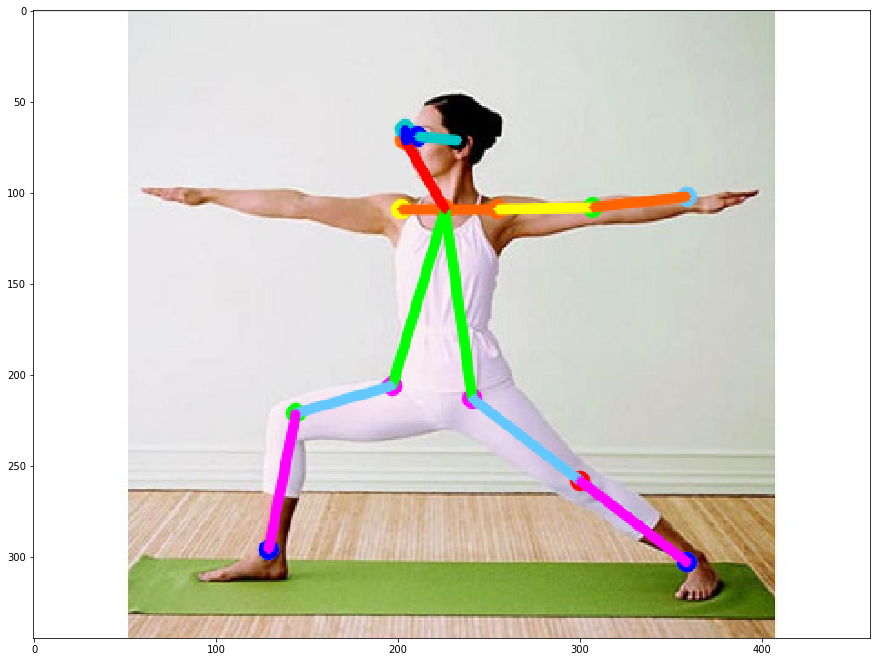

In [19]:
personwiseKeypoints, keypoints_list, frameClone = classify_file(path_to_datasets + "training_set/warrior2/File12.jpg")

for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [ ]:
classify_folder(path_to_datasets + "training_set/warrior2/")